In [ ]:
# plan

# - caclulate monthly Q for different land covers 
# - calculate how on average change in lang cover affect the change in runoff -> transport capacity -> TL case 



# plan
# 1 - calculate the monthly water yeild 
# 2 - plot average + spread per month 


In [1]:
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import os
import seaborn as sns


import functions



# calculate the monthly values in mm 

In [43]:
def water_balance_components_in_mm(hydro, column, area=4830.0):
    """
    Calculate the sum of water or sediment volume per month for a specific column, 
    and return the mean volumes across years.
    
    Parameters:
    hydro (pd.DataFrame): Input DataFrame with columns `D` (date) and the specified numeric column.
    column (str): The name of the column to calculate the volume for.
    area (float): Area in square meters used to scale the volumes. Default is 4830.0.
    
    Returns:
    pd.DataFrame: DataFrame with the calculated monthly volumes.
    """
    # Ensure `D` column is in datetime format
    hydro['D'] = pd.to_datetime(hydro['D'])

    if column == 'snowmelt':
        hydro['snowmelt'] = hydro['snowacc'].where(hydro['snowacc'] < 0).fillna(0)
    if column == 'snowacc2':
        hydro['snowacc2'] = hydro['snowacc'].where(hydro['snowacc'] > 0).fillna(0)
    if column == 'rainfall':
        hydro['rainfall'] = hydro['Pr'] - hydro['snowacc']
        hydro['rainfall'] = hydro['rainfall'].fillna(0)
        
    
    # Scale the specified column by the area
    hydro[column] = hydro[[column]]
    
    # Set 'D' as the index
    hydro = hydro.set_index('D')
    
    # Resample to monthly data and calculate the sum for each month for the specified column
    hydro_month = hydro[column].resample('M').mean().reset_index()
    
    # Extract year and month for grouping or further analysis
    hydro_month['year'] = hydro_month['D'].dt.year
    hydro_month['month'] = hydro_month['D'].dt.month
    
    return hydro_month


In [ ]:
# folders = '/Volumes/6382452/!Feb2024/paper2/model_runs/TL_data/1landcover/langtang_climate_cut'

In [46]:
%%time

# column = 'Pr'  # Set the target column
location = 'langtang'

if location == 'langtang':
    folder_loc = '12a'
if location == 'mustang': 
    folder_loc = '13a'



# landcover1_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/{location}_climate_cut'
# landcover2_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/2landcover/{location}_climate_cut'
# landcover3_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/{location}_climate_cut'
# landcover4_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut' #this one is different - no change in glacier 
# landcover5_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut'





output_path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro'

# Define the list of folder paths

# folder_paths = [f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_30percent/{location}_climate_cut',
#                 f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/2landcover_30percent/{location}_climate_cut',
#                 f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/3landcover_30percent/{location}_climate_cut',
#                 f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/4landcover_30percent/{location}_climate_cut',
#                 f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/5landcover_30percent/{location}_climate_cut']

# folder_paths = [f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_daily/1landcover_30percent/{location}_climate_cut',
#                 f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_daily/2landcover_30percent/{location}_climate_cut',
#                 f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_daily/3landcover_30percent/{location}_climate_cut',
#                 f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_daily/4landcover_30percent/{location}_climate_cut',
#                 f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_daily/5landcover_30percent/{location}_climate_cut']


folder_paths = [f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_daily/1landcover_30percent/{location}_climate_cut']

# Load elevation data and define the output path
elevation = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_and_elevation_with_labels_{location}.csv')[['cellnr2', 'band_data']]
elevation = elevation.transpose()
elevation_list = elevation.loc['cellnr2'].tolist() 


CPU times: user 9.43 ms, sys: 4.16 ms, total: 13.6 ms
Wall time: 11.1 ms


In [47]:
# loop over columns too 
# columns = ['PET', 'AET', 'Q', 'snowacc2', 'snowmelt', 'glacier_melt', 'Pr', 'rainfall']
# columns = ['Pr', 'rainfall']
# columns = ['glacier_melt']
columns = ['Ta']

In [48]:
%%time
print(columns)  # Ensure `columns` is defined as a list of column names

# Iterate over columns
for column in columns:
    print(f"Processing column: {column}")

    # Iterate over folder paths
    for folder_path in folder_paths:
        print(f"Processing folder: {folder_path}")

        output_folder = output_path

        # Extract "1landcover" from the folder path
        landcover_part = os.path.basename(os.path.dirname(folder_path))
        landcover_base = landcover_part.split('_')[0]  # This gives "1landcover"

        # Load timestep DataFrame (assuming Hydro.out exists in the `/12a/` subfolder for all folders)
        hydro_path = os.path.join(folder_path, folder_loc, 'Hydro.out')
        print(f"Checking Hydro.out path: {hydro_path}")

        if not os.path.isfile(hydro_path):
            print(f"Hydro.out not found in {hydro_path}")
            continue  # Skip this folder_path if the main Hydro.out is missing

        # Load the Hydro.out file for timestep calculation
        try:
            dfts = pd.read_csv(hydro_path)
            df = water_balance_components_in_mm(dfts, column, area=4830.0)
            df = df[['month', 'year']]
        except Exception as e:
            print(f"Error loading timestep file: {e}")
            continue

        # Initialize the result DataFrame for this folder_path
        result_df = pd.DataFrame()

        # Iterate over subfolders in the folder path
        for folder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, folder_name)
            
            # Skip files and hidden folders
            if not os.path.isdir(subfolder_path) or folder_name.startswith('.'):
                continue

            file_path = os.path.join(subfolder_path, 'Hydro.out')
            # print(f"Checking subfolder Hydro.out: {file_path}")

            # Ensure the Hydro.out file exists in the subfolder
            if os.path.isfile(file_path):
                try:
                    hydro = pd.read_csv(file_path)
                    output_df = water_balance_components_in_mm(hydro, column)

                    # Extract and rename the target column
                    name_column = output_df[column]
                    column_name = f'{column}_{folder_name}'
                    result_df[column_name] = name_column
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    continue

        # Ensure result_df has data before proceeding
        if result_df.empty:
            print(f"No valid data found in subfolders of {folder_path}")
            continue

        # Rename columns for clarity and filter by elevation list
        result_df.columns = [col[-3:] for col in result_df.columns]  # Adjust column names if necessary
        result_df = result_df[elevation_list]

        # Check for consistency with the elevation list
        if elevation_list == result_df.columns.tolist():
            print("Default land cover. Monthly data: same")

            # Rename columns, merge with timestep, and add folder info
            result_df.columns = elevation.loc['band_data']
            result_df = pd.concat([df, result_df], axis=1)
            result_df['folder'] = os.path.basename(folder_path)

            print(result_df)

            # Define the output file name and save the DataFrame to a CSV file
            output_filename = f'{location}_monthly_sum_elevation_{column}_{landcover_base}_mm.csv'
            print('output filename:', output_filename)
            result_df.to_csv(os.path.join(output_folder, output_filename), index=False)

            print(f"Saved {output_filename}")
        else:
            print(f"The data does not match the elevation list for {folder_path}!")


['Ta']
Processing column: Ta
Processing folder: /Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_daily/1landcover_30percent/langtang_climate_cut
Checking Hydro.out path: /Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_daily/1landcover_30percent/langtang_climate_cut/12a/Hydro.out
Default land cover. Monthly data: same
     month  year    4485.0     3734.0     4880.0     4847.0     3908.0  \
0        9  1989  4.103542   8.985042   1.536042   1.750542   7.894608   
1       10  1989 -0.282397   4.599103  -2.849897  -2.635397   3.802511   
2       11  1989 -5.480642  -0.599142  -8.048142  -7.833642  -1.523982   
3       12  1989 -8.986411  -4.104911 -11.553911 -11.339411  -4.913934   
4        1  1990 -5.750284  -0.868784  -8.317784  -8.103284  -1.866651   
..     ...   ...       ...        ...        ...        ...        ...   
392      5  2022  1.499452   6.380952  -1.068048  -0.853548   5.794545   
393      6  2022  4.779668   9.661168   2.212168   2.426668   9.101194   
394 

# calculate annual total value per wb component 

### to make alluvial diagram across 5 different land covers 
### alluvial diagram should have 5 panels 
### left side: in components
### right side: out

# plots! - water balance components 

In [ ]:
# plot of interest: 
# barplots with + and - components 
# components:
# AET PET Q GLACIER_MELT SNOW_MELT SNOW_ACC 

# + Pr, snow melt, glacier melt
# - AET PET Q 


def prepare_for_boxplots(df, value_name):
    # value name - column in the output dataframe
    melted = pd.melt(df, id_vars=['month','folder', 'year'], var_name='elevation', value_name=value_name)
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    return melted

In [ ]:
# test for landcover 1
landcover_idx = 1
location = 'langtang' # 'mustang'

folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro/'

aet1      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
pet1      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_PET_{landcover_idx}landcover_mm.csv')
Q1        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1   = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
pr1       = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
snowacc1  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowacc2_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


# mustang_monthly_sum_elevation_Pr_1landcover_mm
# mustang_monthly_sum_elevation_snowacc2_2landcover_mm

In [ ]:
aet1_melted = prepare_for_boxplots(aet1, 'AET')
pet1_melted = prepare_for_boxplots(pet1, 'PET')
Q1_melted = prepare_for_boxplots(Q1, 'Q')

glmelt1_melted = prepare_for_boxplots(glmelt1, 'glmelt')
snowmelt1_melted = prepare_for_boxplots(snowmelt1, 'snowmelt')
pr1_melted = prepare_for_boxplots(pr1, 'Pr')
rainfall1_melted = prepare_for_boxplots(rainfall1, 'Pr')
snowacc1_melted = prepare_for_boxplots(snowacc1, 'snowacc')


# make snowmelt not negative 
snowmelt1_melted['snowmelt'] = snowmelt1_melted['snowmelt'] * -1


In [ ]:
fig = plt.figure(figsize=(20, 20), layout = 'tight')
mosaic = fig.subplot_mosaic('''
                            aaa
                            bbb
                            ccc
                            eee
                            fff
                            ggg
                            ''')


sns.barplot(ax = mosaic['a'], x='month', y='Pr', hue = 'elevation_bin', data=pr1_melted, palette = 'magma_r', legend = True) 
sns.barplot(ax = mosaic['b'], x='month', y='AET', hue = 'elevation_bin', data=aet1_melted, palette = 'viridis_r', legend = False) 
sns.barplot(ax = mosaic['c'], x='month', y='PET', hue = 'elevation_bin', data=pet1_melted, palette = 'viridis_r', legend = True)
# sns.barplot(ax = mosaic['d'], x='month', y='snowacc', hue = 'elevation_bin', data=snowacc1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['e'], x='month', y='snowmelt', hue = 'elevation_bin', data=snowmelt1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['f'], x='month', y='glmelt', hue = 'elevation_bin', data=glmelt1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['g'], x='month', y='Q', hue = 'elevation_bin', data=Q1_melted, palette = 'magma_r', legend = False)


sns.move_legend(mosaic['a'], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(mosaic['c'], "upper left", bbox_to_anchor=(1, 1))

# # Adding text to the top-left corner of each subplot
# mosaic['a'].text(0.02, 0.95, 'veg 40%, bedrock 40%, ice 20%', transform=mosaic['a'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['b'].text(0.02, 0.95, 'veg 40%, bedrock 50%, ice 10%', transform=mosaic['b'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['c'].text(0.02, 0.95, 'veg 50%, bedrock 40%, ice 10%', transform=mosaic['c'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['d'].text(0.02, 0.95, 'veg 40%, bedrock 60%, ice 0%',  transform=mosaic['d'].transAxes, fontsize=25, verticalalignment='top')





if landcover_idx ==1:
    plt.suptitle('veg 40%, bedrock 40%, ice 20%', fontsize = 25)
if landcover_idx ==2:
    plt.suptitle('veg 40%, bedrock 50%, ice 10%', fontsize = 25)
if landcover_idx ==3:
    plt.suptitle('veg 50%, bedrock 40%, ice 10%', fontsize = 25)



# vlaues per month

In [ ]:
# List of components (example structure)
wb_components = [aet1_melted, pet1_melted, Q1_melted, glmelt1_melted, snowmelt1_melted, 
                 pr1_melted, snowacc1_melted]


grouped_dfs = []

# Iterate over each component, group by 'month', and compute the mean
for c in wb_components:
    grouped = c.groupby('month').mean().drop(columns=['elevation', 'year'])
    # Add a suffix to the column names to indicate the source DataFrame
    grouped = grouped.add_suffix(f'_lc{landcover_idx}')
    grouped_dfs.append(grouped)

# Concatenate all grouped DataFrames along the columns
result_df = pd.concat(grouped_dfs, axis=1)

# result_df.to_csv(folder + f'wb_components_monthly_mean_{location}_landcover{landcover_idx}.csv')

In [ ]:
wb1 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover1.csv', index_col = 0)
wb2 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover2.csv', index_col = 0)
wb3 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover3.csv', index_col = 0)
wb4 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover4.csv', index_col = 0)
wb5 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover5.csv', index_col = 0)



In [ ]:
fig = plt.figure(figsize=(20, 15), layout = 'tight')
mosaic = fig.subplot_mosaic('''
                            ab
                            cd
                            ef
                            ''')

wb1[['glmelt_lc1', 'snowmelt_lc1', 'Pr_lc1']].plot(ax = mosaic['a'], kind = 'bar', stacked = True, cmap = 'Set2')
wb2[['glmelt_lc2', 'snowmelt_lc2', 'Pr_lc2']].plot(ax = mosaic['b'], kind = 'bar', stacked = True, cmap = 'magma')
wb3[['glmelt_lc3', 'snowmelt_lc3', 'Pr_lc3']].plot(ax = mosaic['c'], kind = 'bar', stacked = True, cmap = 'magma')
wb4[['glmelt_lc4', 'snowmelt_lc4', 'Pr_lc4']].plot(ax = mosaic['d'], kind = 'bar', stacked = True, cmap = 'magma')
wb5[['glmelt_lc5', 'snowmelt_lc5', 'Pr_lc5']].plot(ax = mosaic['e'], kind = 'bar', stacked = True, cmap = 'magma')

wb1[['Q_lc1']].plot(ax = mosaic['a'], kind = 'line')
wb1[['AET_lc1']].plot(ax = mosaic['a'], kind = 'line', stacked = True, cmap = 'Set2')


In [ ]:
# plot so that left column is the dischange and precipitation and temperature 
# right plot is the stacked water balance components - maybe in the % of the dischsnge?
# right plot: IN components - positive, OUT components - negative 


# 'Q'
# IN: 'glmelt_lc1', 'snowmelt_lc1', 'Pr_lc1'
# OUT: 'AET_lc1', 'Q'
# PET_lc1 -? where does that go

In [ ]:
# wb1.columnsPET_lc1

# mean total annual - langtang

In [ ]:
# test for landcover 1
landcover_idx = 5
location = 'langtang' # 'mustang'

folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro/'

aet      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
pet      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_PET_{landcover_idx}landcover_mm.csv')
Q        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt   = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
pr       = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')
rainfall = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
snowacc  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowacc2_{landcover_idx}landcover_mm.csv')
rainfall = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


In [ ]:
glmelt.head()

In [ ]:
# calculate mean annual per column and then average out in space (for all elevations)
def mean_annual_for_all_locations(df):
    grouped = df.groupby('year').sum().iloc[1:-1]
    grouped = grouped.drop(columns = 'month')
    # test = test.iloc[1:-1]
    final = grouped.T.mean()
    return final


snowmelt[snowmelt.select_dtypes(include='number').columns] = snowmelt.select_dtypes(include='number').applymap(
    lambda x: -x if x < 0 else x)


In [ ]:

# Assuming 'wb_components' is a list of dataframes, and each dataframe has a 'year' column
wb_components = [aet, pet, Q, glmelt, snowmelt, pr, snowacc]
wb_names = ['aet', 'pet', 'Q', 'glmelt', 'snowmelt', 'pr', 'snowacc']  # Corresponding names

# Initialize an empty dictionary to store results
results = {}

# Iterate over the dataframes and names
for df, name in zip(wb_components, wb_names):
    results[name] = mean_annual_for_all_locations(df)

# Combine the results into a final dataframe
final_df = pd.DataFrame(results)


# final_df.to_csv(folder + f'wb_components_annual_mean_{location}_landcover{landcover_idx}.csv', index = True)


# mean annual langtang water balance

In [ ]:
def make_annual(df):
    df['rainfall'] = df.pr - df.snowmelt
    df['GW'] = (df.rainfall + df.glmelt + df.snowmelt) - (df.Q + df.aet)
    annual = df.mean().T
    annualdf = pd.DataFrame(annual)
    return annualdf



location = 'langtang'
annual1 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover1.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual2 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover2.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual3 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover3.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual4 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover4.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual5 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover5.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')


annual1 = make_annual(annual1)
annual2 = make_annual(annual2)
annual3 = make_annual(annual3)
annual4 = make_annual(annual4)
annual5 = make_annual(annual5)


# Add a new column for each DataFrame name
annual1['landcover'] = 'land cover 1'
annual2['landcover'] = 'land cover 2'
annual3['landcover'] = 'land cover 3'
annual4['landcover'] = 'land cover 4'
annual5['landcover'] = 'land cover 5'

# Concatenate all DataFrames vertically, using the 'Date' column as the identifier
df_langtang = pd.concat([annual1, annual2, annual3, annual4, annual5])

# Set 'Date' as the index
df_langtang = df_langtang.reset_index()

# Display the merged DataFrame
df_langtang.columns = ['variable', 'value', 'landcover']
df_langtang = df_langtang.set_index('landcover')

df_langtang.head()

In [ ]:
df = df_langtang


# Define the data (same as before, assuming you've already merged them as `df`)
# Add IN and OUT components
in_components = ['glmelt', 'snowmelt', 'rainfall']  # IN components
out_components = ['aet', 'Q', 'GW']   # OUT components

# Separate IN and OUT components from the merged DataFrame
in_df = df[df['variable'].isin(in_components)]
out_df = df[df['variable'].isin(out_components)]

# Pivot the data so that 'Date' is the index and 'Variable' becomes columns for IN and OUT
in_pivot = in_df.pivot_table(index='landcover', columns='variable', values='value', aggfunc='sum')
out_pivot = out_df.pivot_table(index='landcover', columns='variable', values='value', aggfunc='sum')


# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the IN components stacked bar plot
in_pivot.plot(kind='bar', stacked=True, width=0.4, position=1, color=['cyan', 'green', 'blue'], ax=ax)

# Plot the OUT components stacked bar plot
out_pivot.plot(kind='bar', stacked=True, width=0.4, position=0, color=['purple', 'orange', 'red'], ax=ax)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Water Balance Components")
plt.title("Grouped Stacked Bar Plot of IN and OUT Water Balance Components")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title="Components", loc='upper right')#, bbox_to_anchor=(1,1))  # Legend outside the plot

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Q

# mean total annual mustang

In [ ]:
import pandas as pd

landcover_idx = 5
location = 'mustang' # 'mustang'

folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro/'

aet      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
pet      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_PET_{landcover_idx}landcover_mm.csv')
Q        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt   = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
pr       = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')
rainfall = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
snowacc  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowacc2_{landcover_idx}landcover_mm.csv')
rainfall = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')



# calculate mean annual per column and then average out in space (for all elevations)
def mean_annual_for_all_locations(df):
    grouped = df.groupby('year').sum().iloc[1:-1]
    grouped = grouped.drop(columns = 'month')
    # test = test.iloc[1:-1]
    final = grouped.T.mean()
    return final


snowmelt[snowmelt.select_dtypes(include='number').columns] = snowmelt.select_dtypes(include='number').applymap(
    lambda x: -x if x < 0 else x)


In [ ]:

# Assuming 'wb_components' is a list of dataframes, and each dataframe has a 'year' column
wb_components = [aet, pet, Q, glmelt, snowmelt, pr, snowacc]
wb_names = ['aet', 'pet', 'Q', 'glmelt', 'snowmelt', 'pr', 'snowacc']  # Corresponding names

# Initialize an empty dictionary to store results
results = {}

# Iterate over the dataframes and names
for df, name in zip(wb_components, wb_names):
    results[name] = mean_annual_for_all_locations(df)

# Combine the results into a final dataframe
final_df = pd.DataFrame(results)


# final_df.to_csv(folder + f'wb_components_annual_mean_{location}_landcover{landcover_idx}.csv', index = True)


In [ ]:
# final_df

In [ ]:
def make_annual(df):
    df['rainfall'] = df.pr - df.snowmelt
    df['GW'] = (df.rainfall + df.glmelt + df.snowmelt) - (df.Q + df.aet)
    annual = df.mean().T
    annualdf = pd.DataFrame(annual)
    return annualdf


annual1 = pd.read_csv(folder + f'wb_components_annual_mean_mustang_landcover1.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual2 = pd.read_csv(folder + f'wb_components_annual_mean_mustang_landcover2.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual3 = pd.read_csv(folder + f'wb_components_annual_mean_mustang_landcover3.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual4 = pd.read_csv(folder + f'wb_components_annual_mean_mustang_landcover4.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual5 = pd.read_csv(folder + f'wb_components_annual_mean_mustang_landcover5.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')


annual1 = make_annual(annual1)
annual2 = make_annual(annual2)
annual3 = make_annual(annual3)
annual4 = make_annual(annual4)
annual5 = make_annual(annual5)


# Add a new column for each DataFrame name
annual1['landcover'] = 'land cover 1'
annual2['landcover'] = 'land cover 2'
annual3['landcover'] = 'land cover 3'
annual4['landcover'] = 'land cover 4'
annual5['landcover'] = 'land cover 5'

# Concatenate all DataFrames vertically, using the 'Date' column as the identifier
df_mustang = pd.concat([annual1, annual2, annual3, annual4, annual5])

# Set 'Date' as the index
df_mustang = df_mustang.reset_index()

# Display the merged DataFrame
df_mustang.columns = ['variable', 'value', 'landcover']
df_mustang = df_mustang.set_index('landcover')

df_mustang.head()

In [ ]:

df = df_langtang


# Define the data (same as before, assuming you've already merged them as `df`)
# Add IN and OUT components
in_components = ['glmelt', 'snowmelt', 'rainfall']  # IN components
out_components = ['aet', 'Q', 'GW']   # OUT components

# Separate IN and OUT components from the merged DataFrame
in_df = df[df['variable'].isin(in_components)]
out_df = df[df['variable'].isin(out_components)]

# Pivot the data so that 'Date' is the index and 'Variable' becomes columns for IN and OUT
in_pivot = in_df.pivot_table(index='landcover', columns='variable', values='value', aggfunc='sum')
out_pivot = out_df.pivot_table(index='landcover', columns='variable', values='value', aggfunc='sum')







df1 = df_mustang

in_components = ['glmelt', 'snowmelt', 'rainfall']  # IN components
out_components = ['aet', 'Q', 'GW']   # OUT components

# Separate IN and OUT components from the merged DataFrame
in_df1 = df1[df1['variable'].isin(in_components)]
out_df1 = df1[df1['variable'].isin(out_components)]

# Pivot the data so that 'Date' is the index and 'Variable' becomes columns for IN and OUT
in_pivot1 = in_df1.pivot_table(index='landcover', columns='variable', values='value', aggfunc='sum')
out_pivot1 = out_df1.pivot_table(index='landcover', columns='variable', values='value', aggfunc='sum')






In [ ]:
fig = plt.figure(figsize=(20, 6), layout = 'tight')
mosaic = fig.subplot_mosaic('''
                            ab
                            ''')


# LANGTANG
in_pivot.plot(kind='bar', stacked=True, width=0.4, position=1, color=['cyan', 'green', 'blue'], ax=mosaic['a'])

# Plot the OUT components stacked bar plot
out_pivot.plot(kind='bar', stacked=True, width=0.4, position=0, color=['purple', 'orange', 'red'], ax=mosaic['a'])
mosaic['a'].set_title('langtang')



# MUSTANG

# Plot the IN components stacked bar plot
in_pivot1.plot(kind='bar', stacked=True, width=0.4, position=1, color=['cyan', 'green', 'blue'], ax=mosaic['b'], legend = False)

# Plot the OUT components stacked bar plot
out_pivot1.plot(kind='bar', stacked=True, width=0.4, position=0, color=['purple', 'orange', 'red'], ax=mosaic['b'], legend = False)
mosaic['b'].set_title('mustang')


# Set the shared y-axis
mosaic['a'].get_shared_y_axes().join(mosaic['a'], mosaic['b'])

# Optionally, you can adjust the limits to ensure both plots are on the same scale
mosaic['a'].set_ylim([0, max(mosaic['a'].get_ylim()[1], mosaic['b'].get_ylim()[1])])

# Add grid to both axes
mosaic['a'].grid(True, axis='y', linestyle='--', color='gray', alpha=0.7)  # Grid for 'langtang'
mosaic['b'].grid(True, axis='y', linestyle='--', color='gray', alpha=0.7)  # Grid for 'mustang'





In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a figure
fig = plt.figure(figsize=(20, 6), layout='tight')

# Create a mosaic of subplots
mosaic = fig.subplot_mosaic('''
                            ab
                            ''')

# Get the Set2 colormap from matplotlib
colors = cm.get_cmap('Paired', 6)  # 6 colors from Set2 (adjust the number based on your data)

# Plot the IN components stacked bar plot for 'langtang' using Set2 colors
in_pivot.plot(kind='bar', stacked=True, width=0.4, position=1, color=[colors(0), colors(1), colors(2)], ax=mosaic['a'])

# Plot the OUT components stacked bar plot for 'langtang' using Set2 colors
out_pivot.plot(kind='bar', stacked=True, width=0.4, position=0, color=[colors(3), colors(4), colors(5)], ax=mosaic['a'])
mosaic['a'].set_title('langtang')

# Plot the IN components stacked bar plot for 'mustang' using Set2 colors
in_pivot1.plot(kind='bar', stacked=True, width=0.4, position=1, color=[colors(0), colors(1), colors(2)], ax=mosaic['b'])

# Plot the OUT components stacked bar plot for 'mustang' using Set2 colors
out_pivot1.plot(kind='bar', stacked=True, width=0.4, position=0, color=[colors(3), colors(4), colors(5)], ax=mosaic['b'])
mosaic['b'].set_title('mustang')

# Set the shared y-axis
mosaic['a'].get_shared_y_axes().join(mosaic['a'], mosaic['b'])

# Optionally, you can adjust the limits to ensure both plots are on the same scale
mosaic['a'].set_ylim([0, max(mosaic['a'].get_ylim()[1], mosaic['b'].get_ylim()[1])])

# Add grid to both axes
mosaic['a'].grid(True, axis='y', linestyle='--', color='gray', alpha=0.7)  # Grid for 'langtang'
mosaic['b'].grid(True, axis='y', linestyle='--', color='gray', alpha=0.7)  # Grid for 'mustang'

# plt.savefig('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/mean_annual_water_balance_components.png', bbox_inches = 'tight', dpi = 300)

## barplots per month (6th march)

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 


import functions

In [52]:
folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro/'
landcover_idx = 1
location = 'langtang'

aet1      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q1        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1   = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


Ta1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Ta_{landcover_idx}landcover_mm.csv')


In [53]:
landcover_idx = 2

aet2      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q2        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt2  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt2 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall2 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr2 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


landcover_idx = 3
aet3      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q3        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt3  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt3 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall3 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr3 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


landcover_idx = 4
aet4      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q4        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt4  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt4 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall4 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr4 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


landcover_idx = 5
aet5      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q5        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt5  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt5 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall5 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr4 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


In [54]:
# 1. remove folder part 
# 2. melt together with elevation just like everything else 
# 3. make mean monthly values
# 4. plot using seabotn so that there is a spread 


def prepare_for_plot(df, landcover, variable):
    df = df.drop('folder', axis = 1)
    melted = pd.melt(df, id_vars=['year', 'month'], var_name='elevation', value_name='value')
    
    melted['elevation'] = melted['elevation'].astype(str).str.extract(r'^(\d+)')[0].astype(int)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted['date_id'] = melted['year'].astype(str) + "_" + melted['month'].astype(str) + "_" + melted['elevation'].astype(str)
    melted = melted.sort_values('date_id')
    melted['landcover'] = landcover
    melted['variable'] = variable
    return melted 



In [55]:
# dataset names 

# Base dataset names
base_names = ["aet", "Q", "glmelt", "snowmelt", "rainfall"]

# Generate dataset name lists for 2, 3, 4, and 5
dataset_names_all = {i: [f"{name}{i}" for name in base_names] for i in range(1, 6)}

# Access them like this:
dataset_names1 = dataset_names_all[1]
dataset_names2 = dataset_names_all[2]
dataset_names3 = dataset_names_all[3]
dataset_names4 = dataset_names_all[4]
dataset_names5 = dataset_names_all[5]


In [56]:
dataset_names1

['aet1', 'Q1', 'glmelt1', 'snowmelt1', 'rainfall1']

In [57]:

# LANDCOVER 1
# List of dataset names

# Prepare each dataframe and add a column to differentiate them
prepared_dfs = []
for name in dataset_names1:
    df = prepare_for_plot(globals()[name], f"landcover 1", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df = pd.concat(prepared_dfs)


# LANDCOVER 2
prepared_dfs = []
for name in dataset_names2:
    df = prepare_for_plot(globals()[name], f"landcover 2", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df2 = pd.concat(prepared_dfs)



# LANDCOVER 3
prepared_dfs = []
for name in dataset_names3:
    df = prepare_for_plot(globals()[name], f"landcover 3", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df3 = pd.concat(prepared_dfs)



# LANDCOVER 4
prepared_dfs = []
for name in dataset_names4:
    df = prepare_for_plot(globals()[name], f"landcover 4", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df4 = pd.concat(prepared_dfs)




# LANDCOVER 5
prepared_dfs = []
for name in dataset_names5:
    df = prepare_for_plot(globals()[name], f"landcover 5", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df5 = pd.concat(prepared_dfs)



In [58]:
def adjust_data(df):
    df = df.copy()  # Avoid modifying the original data
    df.loc[df["variable"].str.contains(r"\b(?:aet|Q|snowmelt)", regex=True, na=False), "value"] *= -1  
    return df


combined_df  =adjust_data(combined_df)
combined_df2 =adjust_data(combined_df2)
combined_df3 =adjust_data(combined_df3)
combined_df4 =adjust_data(combined_df4)
combined_df5 =adjust_data(combined_df5)



# - langtang temperature 
Ta_langtang = prepare_for_plot(Ta1, 'landcover 1', 'Ta')


In [59]:

# fig = plt.figure(figsize=(20, 5), layout='tight')
# mosaic = fig.subplot_mosaic('''
#                             abcde
#                             ''')


# palette = 'icefire'

# sns.barplot(data=combined_df,  x="month", y="value", hue="variable", ax=mosaic['a'], palette = palette, dodge=True, width=1.5)
# sns.barplot(data=combined_df2, x="month", y="value", hue="variable", ax=mosaic['b'], palette = palette, dodge=True, width=1.5, legend = False)
# sns.barplot(data=combined_df3, x="month", y="value", hue="variable", ax=mosaic['c'], palette = palette, dodge=True, width=1.5, legend = False)
# sns.barplot(data=combined_df4, x="month", y="value", hue="variable", ax=mosaic['d'], palette = palette, dodge=True, width=1.5, legend = False)
# sns.barplot(data=combined_df5, x="month", y="value", hue="variable", ax=mosaic['e'], palette = palette, dodge=True, width=1.5, legend = False)

# # Adjust y-axis limits if necessary
# for ax in mosaic.values():
#     ax.axhline(0, color='black', linewidth=1)  # Add a baseline at y=0
#     ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])  # Ensure limits accommodate negative values

# plt.show()



# for key in ['b', 'c', 'd', 'e']:
#     # mosaic[key].set_yticklabels([])
#     mosaic[key].set_ylabel('')


# for key in ['a', 'b', 'c', 'd', 'e']:
#     # mosaic[key].set_yticklabels([])
#     # mosaic[key].set_xlabel('total df volume')
#     # mosaic[key].set_ylabel('total df count')
#     mosaic[key].set_ylim(-700, 600)



In [60]:
# location = 'mustang'
landcover_idx = 1

aet1      = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q1        = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1   = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt1 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Ta1 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Ta_{landcover_idx}landcover_mm.csv')


landcover_idx = 2

aet2      = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q2        = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt2   = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt2 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall2 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


landcover_idx = 3
aet3      = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q3        = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt3   = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt3 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall3 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


landcover_idx = 4
aet4      = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q4        = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt4   = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt4 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall4 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


landcover_idx = 5
aet5      = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q5        = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt5   = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt5 = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall5 = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')



# dataset names 

# Base dataset names
base_names = ["aet", "Q", "glmelt", "snowmelt", "rainfall"]

# Generate dataset name lists for 2, 3, 4, and 5
dataset_names_all = {i: [f"{name}{i}" for name in base_names] for i in range(1, 6)}

# Access them like this:
dataset_names1 = dataset_names_all[1]
dataset_names2 = dataset_names_all[2]
dataset_names3 = dataset_names_all[3]
dataset_names4 = dataset_names_all[4]
dataset_names5 = dataset_names_all[5]

Ta_mustang = prepare_for_plot(Ta1, 'landcover 1', 'Ta')


In [61]:
glmelt1

,month,year,3689.0,2546.0,3964.0,2571.0,2886.0,3795.0,3540.0,4420.0,...,4785.0,4439.0,4593.0,4603.0,4733.0,4905.0,4952.0,4812.0,4889.0,folder
0,9,1989,444.443658,909.827538,332.924504,899.648538,860.860018,490.751578,594.577378,237.818024,...,295.499679,447.176339,385.843346,381.953108,332.781827,283.956502,267.675496,318.202988,289.820415,mustang_climate_cut
1,10,1989,201.047119,647.824174,126.611544,637.063859,563.013820,208.692588,297.284666,60.000888,...,79.250264,152.071148,121.127865,119.308706,96.626357,69.677861,63.560032,83.221808,71.826684,mustang_climate_cut
2,11,1989,38.653173,313.373056,13.255615,304.628664,248.997367,42.012381,78.562008,0.000000,...,10.919635,42.484444,27.944371,27.131230,17.923269,7.362155,5.970139,10.772405,7.861357,mustang_climate_cut
3,12,1989,0.000000,144.734715,0.000000,138.885700,105.851004,4.585578,23.597346,0.000000,...,0.000000,7.795290,3.500047,3.243991,0.963077,0.000000,0.000000,0.000000,0.000000,mustang_climate_cut
4,1,1990,42.882365,316.130062,8.908368,307.760387,261.607996,52.959949,92.557110,0.000000,...,4.563662,31.444301,20.263616,19.718134,12.541774,4.401204,3.426064,7.375751,5.077170,mustang_climate_cut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,5,2022,365.476529,857.993462,253.098318,847.112462,766.168467,374.266185,482.249293,134.570913,...,212.016349,350.871186,296.274224,292.850398,251.043413,205.718192,193.521409,231.588475,210.175722,mustang_climate_cut
393,6,2022,548.425721,1029.857321,432.924255,1019.327321,955.597301,572.726501,680.132501,310.235176,...,464.957515,623.702692,558.837892,554.625892,500.053068,440.296085,421.403684,478.427648,446.791376,mustang_climate_cut
394,7,2022,633.625763,1131.105083,513.934763,1120.224083,1059.460721,663.827561,774.813761,391.802561,...,499.038712,635.567478,568.540518,564.188118,507.606918,439.314291,418.858011,479.791611,446.278131,mustang_climate_cut
395,8,2022,619.669601,1117.148921,499.978601,1106.267921,1043.279946,647.646786,758.632986,375.669583,...,468.882573,611.608376,544.608392,540.261842,483.759948,410.457682,390.172714,450.761273,417.384864,mustang_climate_cut


In [62]:
# Ta_langtang

In [63]:

# LANDCOVER 1
# List of dataset names
# dataset_names = ["aet1", "Q1", "glmelt1", "snowmelt1", "rainfall1"]

# LANDCOVER 1
prepared_dfs = []
for name in dataset_names1:
    df = prepare_for_plot(globals()[name], f"landcover 2", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df1m = pd.concat(prepared_dfs)


# LANDCOVER 2
prepared_dfs = []
for name in dataset_names2:
    df = prepare_for_plot(globals()[name], f"landcover 2", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df2m = pd.concat(prepared_dfs)



# LANDCOVER 3
prepared_dfs = []
for name in dataset_names3:
    df = prepare_for_plot(globals()[name], f"landcover 3", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df3m = pd.concat(prepared_dfs)



# LANDCOVER 4
prepared_dfs = []
for name in dataset_names4:
    df = prepare_for_plot(globals()[name], f"landcover 4", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df4m = pd.concat(prepared_dfs)




# LANDCOVER 5
prepared_dfs = []
for name in dataset_names5:
    df = prepare_for_plot(globals()[name], f"landcover 5", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df5m = pd.concat(prepared_dfs)




combined_dfm  =adjust_data(combined_df1m)
combined_df2m =adjust_data(combined_df2m)
combined_df3m =adjust_data(combined_df3m)
combined_df4m =adjust_data(combined_df4m)
combined_df5m =adjust_data(combined_df5m)



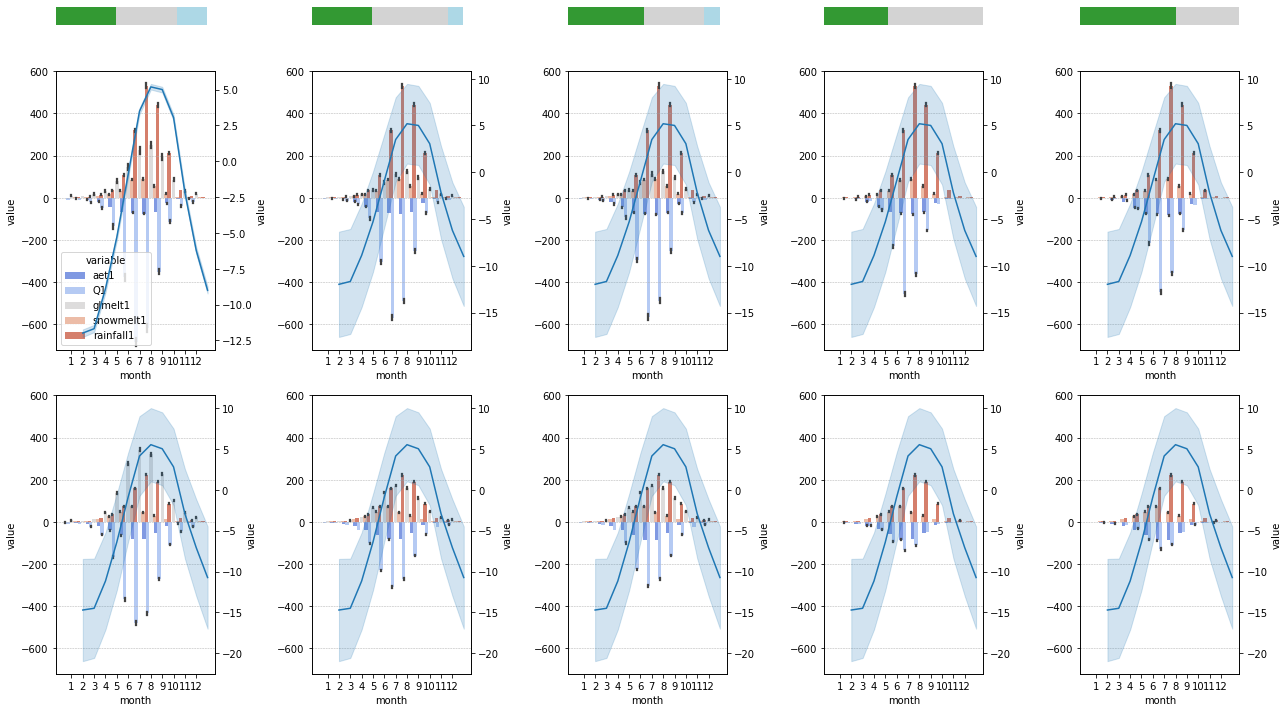

In [74]:
fig = plt.figure(figsize=(18, 10), layout='tight')
mosaic = fig.subplot_mosaic('''
                            klmno
                            abcde
                            abcde
                            abcde
                            abcde
                            abcde
                            ABCDE
                            ABCDE
                            ABCDE
                            ABCDE
                            ABCDE
                            ''')


palette = 'coolwarm'


axa = mosaic['a'].twinx()
axb = mosaic['b'].twinx()
axc = mosaic['c'].twinx()
axd = mosaic['d'].twinx()
axe = mosaic['e'].twinx()

axA = mosaic['A'].twinx()
axB = mosaic['B'].twinx()
axC = mosaic['C'].twinx()
axD = mosaic['D'].twinx()
axE = mosaic['E'].twinx()





sns.barplot(data=combined_df,  x="month", y="value", hue="variable", ax=mosaic['a'], palette = palette, dodge=True, width=1.5)
sns.barplot(data=combined_df2, x="month", y="value", hue="variable", ax=mosaic['b'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df3, x="month", y="value", hue="variable", ax=mosaic['c'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df4, x="month", y="value", hue="variable", ax=mosaic['d'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df5, x="month", y="value", hue="variable", ax=mosaic['e'], palette = palette, dodge=True, width=1.5, legend = False)

sns.barplot(data=combined_dfm,  x="month", y="value", hue="variable", ax=mosaic['A'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df2m, x="month", y="value", hue="variable", ax=mosaic['B'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df3m, x="month", y="value", hue="variable", ax=mosaic['C'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df4m, x="month", y="value", hue="variable", ax=mosaic['D'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df5m, x="month", y="value", hue="variable", ax=mosaic['E'], palette = palette, dodge=True, width=1.5, legend = False)





sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axa, errorbar='ci')
sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axb, errorbar='sd')
sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axc, errorbar='sd')
sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axd, errorbar='sd')
sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axe, errorbar='sd')




sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axA, errorbar='sd')
sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axB, errorbar='sd')
sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axC, errorbar='sd')
sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axD, errorbar='sd')
sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axE, errorbar='sd')








for key in ['b', 'c', 'd', 'e', 'B', 'C', 'D', 'E']:
    mosaic[key].set_ylabel('')


for key in ['a', 'b', 'c', 'd', 'e', 'A', 'B', 'C', 'D', 'E']:
    # mosaic[key].set_xlabel('total df volume')
    mosaic[key].set_ylim(-720, 600)

for key in ['a', 'b', 'c', 'd', 'e', 'A', 'B', 'C', 'D', 'E']:
    mosaic[key].grid(axis='y', linestyle='--', linewidth=0.5) 


# color bar for land cover shares 

# Define color proportions for each panel (Green, Yellow, Gray)
shares = [
    (40, 40, 20),  # First bar: 40% green (veg) , 30% grey (bedrock), 30% blue (glacier)
    (40, 50, 10),
    (50, 40, 10),
    (40, 60, 00),
    (60, 40, 00),
]

# Iterate over the bar row and create the proportional bars
for i, key in enumerate("klmno"):
    bar_ax = mosaic[key]  # Select the correct subplot for the bar

    # Remove ticks, labels, and spines
    bar_ax.set_xticks([])
    bar_ax.set_yticks([])
    bar_ax.set_frame_on(False)

    # Extract proportions (must sum to 100%)
    p1, p2, p3 = shares[i]  # Green, Yellow, Gray

    # Convert percentages to width (normalized to 1)
    p1 /= 100
    p2 /= 100
    p3 /= 100

    # Plot the three segments
    bar_ax.barh(0, p1, height=1, color='green', align='center', alpha = 0.8)
    bar_ax.barh(0, p2, height=1, color='lightgray', left=p1, align='center')
    bar_ax.barh(0, p3, height=1, color='lightblue', left=p1 + p2, align='center')


# plt.savefig('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/monthly_WB_components.png', bbox_inches = 'tight', dpi = 300)

<AxesSubplot:label='e', xlabel='month', ylabel='value'>

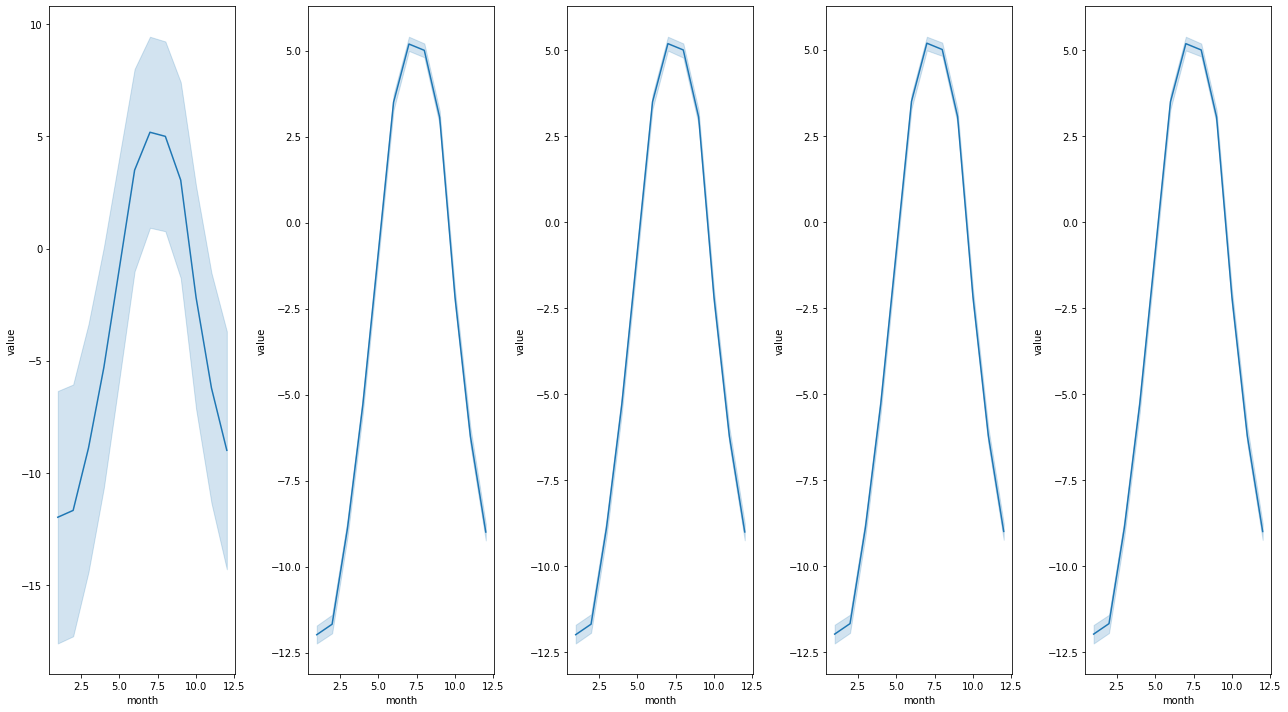

In [71]:
fig = plt.figure(figsize=(18, 10), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')


sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=mosaic['a'], errorbar='sd')#, palette = palette, dodge=True, width=1.5)
sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=mosaic['b'])#, palette = palette, dodge=True, width=1.5)
sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=mosaic['c'])#, palette = palette, dodge=True, width=1.5)
sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=mosaic['d'])#, palette = palette, dodge=True, width=1.5)
sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=mosaic['e'])#, palette = palette, dodge=True, width=1.5)



In [42]:
Ta_langtang

,year,month,elevation,value,elevation_bin,date_id,landcover,variable
398,1989,10,2546,7567.584354,2500 - 3000,1989_10_2546,landcover 1,Ta
1192,1989,10,2571,7446.684354,2500 - 3000,1989_10_2571,landcover 1,Ta
5162,1989,10,2779,6741.807924,2500 - 3000,1989_10_2779,landcover 1,Ta
1589,1989,10,2886,6619.945908,2500 - 3000,1989_10_2886,landcover 1,Ta
14690,1989,10,2981,5761.094528,2500 - 3000,1989_10_2981,landcover 1,Ta
...,...,...,...,...,...,...,...,...
32553,2022,9,5895,-1909.664820,5500 - 6000,2022_9_5895,landcover 1,Ta
69077,2022,9,5908,-1128.263150,5500 - 6000,2022_9_5908,landcover 1,Ta
69871,2022,9,5909,-1132.943150,5500 - 6000,2022_9_5909,landcover 1,Ta
33744,2022,9,5960,-2086.923240,5500 - 6000,2022_9_5960,landcover 1,Ta


In [ ]:
sns.diverging_palette(250, 30, l=65, center="light", as_cmap=True)


In [ ]:
combined_df4m

In [ ]:
(combined_df5m.value - combined_df4m.value).plot()
# (combined_df4m.value - combined_df3m.value).plot()

In [ ]:
(combined_dfm.value - combined_df.value).plot()

# plot distribution of water balance components per elevation